# Currently, I am using world population to test the platform
 - The latest data from the World Bank is the global population from year 1960 until 2016.
 - You can find the population growing over the years. 
 - You also can find it in the world map.
 ---

In [1]:
# import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from ipywidgets import interactive
from ipywidgets import interact
%matplotlib inline


In [2]:
# read in population data from internet
import pandas as pd 
import datapackage

data_url = 'https://datahub.io/JohnSnowLabs/population-figures-by-country/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        df = pd.read_csv(resource.descriptor['path'])
df.set_index("Country_Code", inplace = True) 

# df.head()
# print(df.shape)
# the most recent year: 2016
df16= df.iloc[:, -1]
# df16.sort_values().tail(20)


In [3]:
# retrieve data to get alpha-3 for countries
url = "https://gist.githubusercontent.com/tadast/8827699/raw/3cd639fa34eec5067080a61c69e3ae25e3076abb/countries_codes_and_coordinates.csv"
df_code3 = pd.read_csv(url)
code3 = df_code3["Alpha-3 code"][0]

# for i, c in enumerate(code3):
#     print(i,c)
# # the length is not 3, and the longtitude/latitude have the same problem. 

# reset to 
df_code3["Code3"] = df_code3["Alpha-3 code"].map(lambda x: x.strip()[1:-1] )
df_code3["Lat"] = df_code3["Latitude (average)"].map(lambda x: x.strip()[1:-1]) 
df_code3["Long"] = df_code3["Longitude (average)"].map(lambda x: x.strip()[1:-1]) 

# set index 
df_code3.set_index("Code3", inplace=True )

# keep only the long and lat cols.
df_code3=df_code3.iloc[:, [-2, -1]]
# df_code3.shape # 256 rows

# there are no missing value, but some duplicated: 24 rows
df_code3.isna().sum() # none

# du=df_code3[df_code3.duplicated()] # 24 : 12 are extra
# print(du.size)

#remove
df_code3 = df_code3.drop_duplicates()
# df_code3

In [4]:
# Two dataframe join: use left-join-right
df_m= df_code3.join(df) 
# df_m

# some country's name is missing: 32 countries
df_m.Country.isna().sum()

# # keep only the country which has name in it 
df_good = df_m[df_m.Country.notna()]

# df_good
# set-index by Country name
df_good.set_index(["Country"], inplace=True)

# no duplicated
# df_good[df_good.duplicated()].sum().sum()

# # Population top 10 in 2016
df_2016 =pd.DataFrame(df_good.loc[:, 'Year_2016'])
df_2016.dropna(inplace=True)


#  Top 10 Country Populations in Year 2016

In [5]:
df_2016.sort_values(by="Year_2016", ascending =False).head(10).applymap(lambda x:int(x)) 

,Year_2016
Country,
China,1378665000
India,1324171354
United States,323127513
Indonesia,261115456
Brazil,207652865
Pakistan,193203476
Nigeria,185989640
Bangladesh,162951560
Russian Federation,144342396


In [7]:
# In year 2016, top n
def f_bar(Top_n_2016):
    df_top=df_2016.sort_values(by="Year_2016", ascending=False).head(Top_n_2016)
    df_top.plot(kind = 'pie',  subplots= True, figsize=(15,15), legend = None)
    plt.title(" Top counties in year 2016")
    plt.show()  
    
    
# bar by country    
if __name__ == "__main__": 
    interact(f_bar, Top_n_2016=(1,20))

interactive(children=(IntSlider(value=10, description='Top_n_2016', max=20, min=1), Output()), _dom_classes=('…

#  Global population changes over time

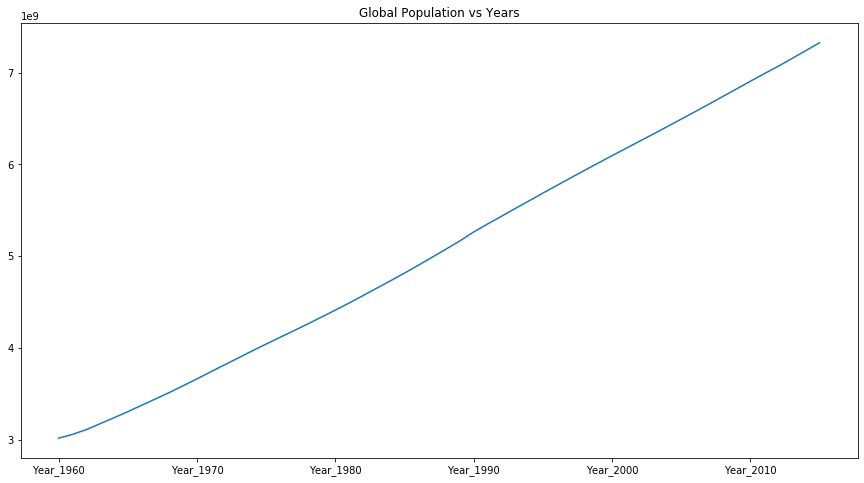

In [8]:
# find the total of each year
Total_all_year = df_good.iloc[:, 2:-1].sum()

Total_all_year.plot(figsize=(15, 8), title = "Global Population vs Years")
plt.show()

# Population Changes Country by Country

In [9]:
# interact:  Draw a year-year for each country
def f_bar(Country):
    df_good.loc[Country, "Year_1960":"Year_2016"].plot( kind= "bar", color=['r', 'b', 'g','k'], figsize=(15,5))
    plt.title(" Population change of each country ")

    
# drop box by country    
if __name__ == "__main__": 
    interact(f_bar, Country=df_good.index)

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'American …

# Population for Each County over 1960-2016

In [12]:
# remove the longitude and latitude
df_year = df_good.iloc[:, 2:].T # change the year only as index


# by line 
def f_slide(Year):
    ind = Year-1960
    df_xy = df_year.iloc[ind, :]
    df_xy.plot(kind= "bar", figsize=(30,10));
    plt.title(" Population - year")
    
# use the country_data: change by year    
if __name__ == "__main__":
    interact(f_slide, Year=(1960, 2016) )
#     interact(f_line, year=(df_year.index))   #n=(1,20)

interactive(children=(IntSlider(value=1988, description='Year', max=2016, min=1960), Output()), _dom_classes=(…

# 2016 Global Population Map## 

In [14]:
#one missing 
df_good[df_good.Year_2016.isna()]

# # keep all non-na
df_good = df_good[df_good.Year_2016.notna()]

import folium
world_map = folium.Map(location=[11,0], 
                      
                       zoom_start=1, max_zoom = 10, min_zoom = 2)

for i in range(0,len(df_good)):
    folium.Circle(
        location=[df_good.iloc[i]['Lat'], df_good.iloc[i]['Long']],
        fill=True,
        radius=( df_good.iloc[i,-1]/1000),
        color='blue',
        tooltip = "<div style='margin: 0; background-color: black; color: white;'>"+
                    "<h4 style='text-align:center;font-weight: bold'>"+ df_good.index[i] + "</h4>"
                    "<hr style='margin:10px;color: white;'>"+
                    "<ul style='color: white;;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
                        "<li>2016 Population: "+str(int(df_good.iloc[i,-1]) )+"</li>"+
                    "</ul></div>",
        fill_color='indigo',
        ).add_to(world_map)

world_map

# Voila to Heroku.

**More is coming soon**